In [9]:
!pip install torch torchvision torchviz matplotlib graphviz


In [18]:
import torch
import torch.nn as nn
import torchviz
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Auto-padding function
def autopad(k, p=None, d=1):
    return p if p is not None else (k - 1) * d // 2

class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""

    default_act = nn.SiLU()  # default activation
    #(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True)
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        #(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True)
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Perform transposed convolution of 2D data."""
        return self.act(self.conv(x))

class ECAConv(nn.Module):
    """Efficient Channel Attention (ECA) module"""
    def __init__(self, c, b=1, gamma=2):
        super().__init__()
        k = int(abs((torch.log2(torch.tensor(c)) + b) / gamma))
        k = k if k % 2 else k + 1  # Ensure k is odd
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k // 2, bias=False)

    def forward(self, x):
        y = torch.mean(x, dim=(2, 3), keepdim=True)  # Global average pooling
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        return x * torch.sigmoid(y)

class GSConv(nn.Module):
    """Ghost Shuffle Convolution for efficient feature extraction"""
    def __init__(self, c1, c2, k=3, s=1, p=None, g=1, d=1):
        super().__init__()
        c_ = c2 // 2  # Half channels
        self.primary_conv = nn.Conv2d(c1, c_, k, s, p, groups=g, dilation=d, bias=False)
        self.cheap_conv = nn.Conv2d(c_, c_, 1, 1, bias=False)  # Ghost Feature Generation

    def forward(self, x):
        y1 = self.primary_conv(x)
        y2 = self.cheap_conv(y1)
        return torch.cat([y1, y2], dim=1)  # Channel-wise concatenation

class EfficientConv(nn.Module):
    """Efficient Convolution block combining Conv2d, GSConv, and ECA attention"""
    def __init__(self, c1, c2, k=3, s=1, p=1, g=1, d=1, act=True, use_bn=True, attention=True):
        super().__init__()
        c_half = c2 // 2  # Split channels for Conv2d and GSConv
        self.conv = nn.Conv2d(c1, c_half, k, s, p, groups=g, dilation=d, bias=False)
        self.gsconv = GSConv(c1, c_half, k, s, p, g, d)  # Efficient convolution
        self.bn = nn.BatchNorm2d(c2) if use_bn else nn.Identity()
        self.act = nn.SiLU() if act else nn.Identity()
        self.eca = ECAConv(c2) if attention else nn.Identity()  # Efficient Channel Attention

    def forward(self, x):
        y1 = self.conv(x)
        y2 = self.gsconv(x)
        y = torch.cat([y1, y2], dim=1)  # Concatenation
        return self.act(self.eca(self.bn(y)))  # Final output

# Create EfficientConv Block
efficient_conv_block = EfficientConv(c1=3, c2=16)  # Example with 3 input channels, 16 output channels

# Create a dummy input tensor (batch=1, channels=3, height=32, width=32)
x = Variable(torch.randn(1, 3, 32, 32))

# Forward pass
y = efficient_conv_block(x)

# Generate a structured computational graph using torchviz
dot = torchviz.make_dot(y, params=dict(efficient_conv_block.named_parameters()), show_attrs=False, show_saved=True)

# Save the diagram in high-quality formats
dot.format = "pdf"  # Best for research papers
dot.render("EfficientConv_Diagram")

dot.format = "svg"  # Vector format for scalable graphics
dot.render("EfficientConv_Diagram_SVG")

print("Diagram saved as EfficientConv_Diagram.pdf and EfficientConv_Diagram_SVG.svg")

# Display in Jupyter Notebook (optional)
#img = plt.imread("EfficientConv_Diagram.png")
#plt.figure(figsize=(10, 10))
#plt.imshow(img)
#plt.axis("off")
##plt.show()


Diagram saved as EfficientConv_Diagram.pdf and EfficientConv_Diagram_SVG.svg


**install thop**

In [2]:
!pip install torchinfo thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [19]:
import torch
import torch.nn as nn
from torchinfo import summary
from thop import profile

# Define input tensor shape (batch size, channels, height, width)
input_tensor = torch.randn(1, 3, 32, 32)  # Example: RGB image of size 32x32

# Define SlimNeckBlock
slimneck = Conv(c1=3, c2=64).eval()  # Set to eval mode

# Compute Number of Parameters using torchinfo
print("\n--- Model Summary (Parameters) ---\n")
summary(slimneck, input_size=(1, 3, 32, 32))  # Detailed architecture summary

# Compute FLOPs and Parameters using thop
flops, params = profile(slimneck, inputs=(input_tensor,))
print(f"\n--- Computational Complexity ---\n")
print(f"Total FLOPs: {flops:.2f}")
print(f"Total Parameters: {params:,}")  # Format with commas



--- Model Summary (Parameters) ---

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.

--- Computational Complexity ---

Total FLOPs: 458752.00
Total Parameters: 320.0


**install fvcore**

In [5]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=1f72e186abbe7c44516b665615bc1939b5e32cbd6878749beabbfe57cfab91e8
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=17429508730ba516eb63a527d0dd4a535d5d5db2cfbb91bb2cfe8cb541789cf5
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


**compare omplexity**

**Efficient conv block and Conv block**

In [20]:
import torch
from thop import profile
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Define input tensor (batch_size=1, channels=3, height=224, width=224)
x = torch.randn(1, 3, 32, 32)

# Initialize models
conv_block = Conv(3, 64, k=3, s=1, p=1)
efficient_conv_block = EfficientConv(3, 64, k=3, s=1, p=1)

# Compute FLOPs and Parameters using THOP
conv_flops, conv_params = profile(conv_block, inputs=(x,), verbose=False)
eff_flops, eff_params = profile(efficient_conv_block, inputs=(x,), verbose=False)

print("THOP Results:")
print(f"Conv FLOPs: {conv_flops:.2f}, Parameters: {conv_params:.2f}")
print(f"EfficientConv FLOPs: {eff_flops:.2f}, Parameters: {eff_params:.2f}")

# Compute FLOPs using fvcore
conv_flop_analysis = FlopCountAnalysis(conv_block, x)
eff_flop_analysis = FlopCountAnalysis(efficient_conv_block, x)

print("\nFVCore Results:")
print(f"Conv FLOPs (fvcore): {conv_flop_analysis.total()}")
print(f"EfficientConv FLOPs (fvcore): {eff_flop_analysis.total()}")

# Print parameter count using fvcore
print("\nParameter Count:")
print("Conv Block:")
print(parameter_count_table(conv_block))
print("EfficientConv Block:")
print(parameter_count_table(efficient_conv_block))

THOP Results:
Conv FLOPs: 2031616.00, Parameters: 1856.00
EfficientConv FLOPs: 1851584.00, Parameters: 1683.00

FVCore Results:
Conv FLOPs (fvcore): 2097152
EfficientConv FLOPs (fvcore): 1917120

Parameter Count:
Conv Block:
| name          | #elements or shape   |
|:--------------|:---------------------|
| model         | 1.9K                 |
|  conv         |  1.7K                |
|   conv.weight |   (64, 3, 3, 3)      |
|  bn           |  0.1K                |
|   bn.weight   |   (64,)              |
|   bn.bias     |   (64,)              |
EfficientConv Block:
| name                          | #elements or shape   |
|:------------------------------|:---------------------|
| model                         | 1.7K                 |
|  conv                         |  0.9K                |
|   conv.weight                 |   (32, 3, 3, 3)      |
|  gsconv                       |  0.7K                |
|   gsconv.primary_conv         |   0.4K               |
|    gsconv.primary_conv.we

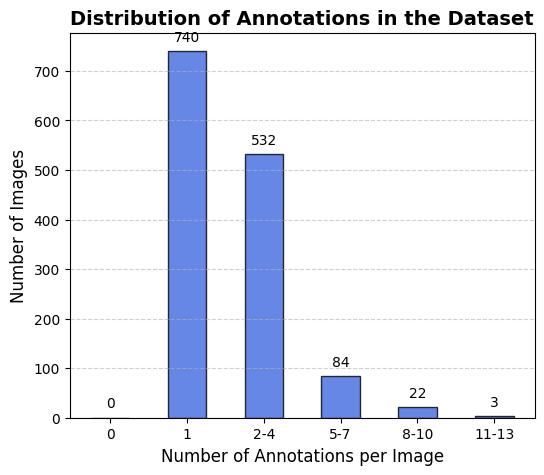

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ["0", "1", "2-4", "5-7", "8-10", "11-13"]
image_counts = [0, 740, 532, 84, 22, 3]

# Plotting
plt.figure(figsize=(6, 5))  # Reduce width while maintaining readability
plt.bar(categories, image_counts, color="royalblue", edgecolor="black", alpha=0.8, width=0.5)

# Labels and title
plt.xlabel("Number of Annotations per Image", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Distribution of Annotations in the Dataset", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show values on top of bars
for i, count in enumerate(image_counts):
    plt.text(i, count + 20, str(count), ha="center", fontsize=10)

# Save as high-resolution PNG (suitable for academic writing)
plt.savefig("annotation_distribution.png", dpi=400, bbox_inches="tight")

# Show plot
plt.show()


**Heatmap plots**

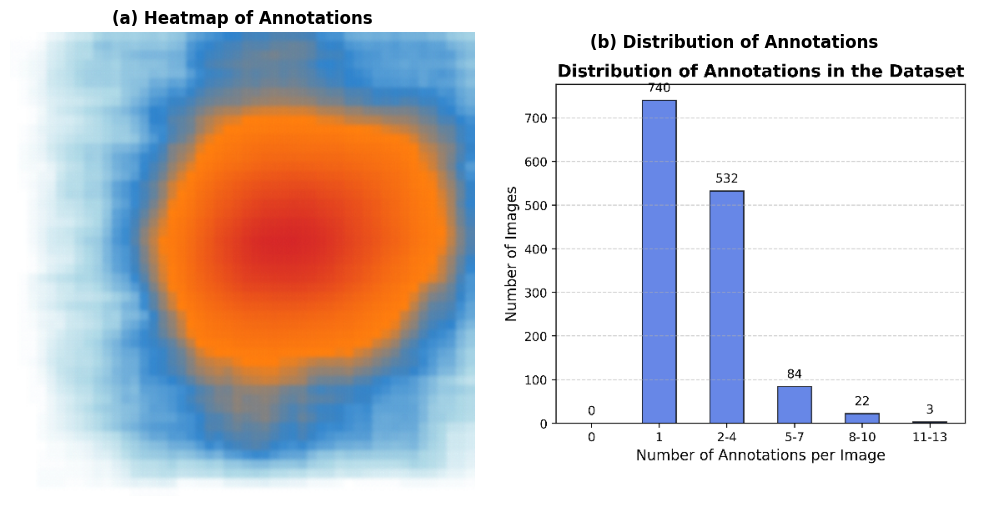

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load images
image1 = cv2.imread("heatmap.png")  # First image
image2 = cv2.imread("annotation_distribution.png")  # Second image

# Convert BGR (OpenCV default) to RGB for correct display in Matplotlib
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Find the maximum height of both images and resize them while maintaining aspect ratio
max_height = min(image1.shape[0], image2.shape[0])  # Use the smaller height to standardize
width1 = int((max_height / image1.shape[0]) * image1.shape[1])  # Scale width proportionally
width2 = int((max_height / image2.shape[0]) * image2.shape[1])  # Scale width proportionally

# Resize images to have the same height
image1_resized = cv2.resize(image1, (width1, max_height))
image2_resized = cv2.resize(image2, (width2, max_height))

# Create a figure with controlled width
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust width to fit both images properly

# Display first image
axes[0].imshow(image1_resized)
axes[0].set_title("(a) Heatmap of Annotations", fontsize=12, fontweight="bold")
axes[0].axis("off")  # Hide axes for better appearance

# Display second image
axes[1].imshow(image2_resized)
axes[1].set_title("(b) Distribution of Annotations", fontsize=12, fontweight="bold")
axes[1].axis("off")  # Hide axes for better appearance

# Adjust layout
plt.tight_layout()
plt.savefig("combined_images.png", dpi=300, bbox_inches="tight")  # Save high-resolution image for manuscript
plt.show()


**paired t-tests and Cohen’s d values (< 0.2)**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Load the CSV files
yolo8n_original = load_data('/content/yolov8_model.csv')
yolo8n_proposed = load_data('/content/proposed_model.csv')

# Extract mAP50 and mAP95 values for paired t-test
original_map50 = yolo8n_original['metrics/mAP50(B)'].values
proposed_map50 = yolo8n_proposed['metrics/mAP50(B)'].values

original_map95 = yolo8n_original['metrics/mAP50-95(B)'].values
proposed_map95 = yolo8n_proposed['metrics/mAP50-95(B)'].values

# Perform paired t-tests
map50_t, map50_p = ttest_rel(original_map50, proposed_map50)
map95_t, map95_p = ttest_rel(original_map95, proposed_map95)

# Calculate Cohen's d
def cohens_d(x, y):
    diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)
    return diff / pooled_std

d_map50 = cohens_d(original_map50, proposed_map50)
d_map95 = cohens_d(original_map95, proposed_map95)

# Display results
print(f"Paired t-test results:")
print(f"mAP@50: t-value = {map50_t:.2f}, p-value = {map50_p:.3f}")
print(f"mAP@95: t-value = {map95_t:.2f}, p-value = {map95_p:.3f}")
print("\nCohen's d effect size:")
print(f"mAP@50: d = {d_map50:.2f}")
print(f"mAP@95: d = {d_map95:.2f}")


Paired t-test results:
mAP@50: t-value = -4.47, p-value = 0.000
mAP@95: t-value = -6.56, p-value = 0.000

Cohen's d effect size:
mAP@50: d = -0.10
mAP@95: d = -0.15


**Wilcoxon Signed-Rank Test**

In [ ]:
from scipy.stats import wilcoxon

# Apply Wilcoxon Signed-Rank Test
wilcoxon_map50 = wilcoxon(yolo8n_original_map50, yolo8n_proposed_map50)
wilcoxon_map95 = wilcoxon(yolo8n_original_map95, yolo8n_proposed_map95)

print(f"Wilcoxon Signed-Rank Test Results:")
print(f"mAP@50: W-statistic = {wilcoxon_map50.statistic}, p-value = {wilcoxon_map50.pvalue}")
print(f"mAP@95: W-statistic = {wilcoxon_map95.statistic}, p-value = {wilcoxon_map95.pvalue}")


Wilcoxon Signed-Rank Test Results:
mAP@50: W-statistic = 6.0, p-value = 0.02734375
mAP@95: W-statistic = 3.0, p-value = 0.009765625
